# Classification Transformer Model
Finds the tone of an article based on the article's headline, abstract and key words

In [ ]:
conda install tensorflow

In [14]:
import tensorflow as tf
from keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
def transformer_block(embed_dim, num_heads, ff_dim, dropout_rate):
    att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    ffn = Sequential(
        [Dense(ff_dim, activation="relu"),
         Dense(embed_dim), ]
    )
    layernorm1 = LayerNormalization(epsilon=1e-6)
    layernorm2 = LayerNormalization(epsilon=1e-6)
    dropout1 = Dropout(dropout_rate)
    dropout2 = Dropout(dropout_rate)
    
    def call(inputs, training):
        attn_output = att(inputs, inputs)
        attn_output = dropout1(attn_output, training=training)
        out1 = layernorm1(inputs + attn_output)
        ffn_output = ffn(out1)
        ffn_output = dropout2(ffn_output, training=training)
        return layernorm2(out1 + ffn_output)
    
    return call

In [5]:
# Load training data
train_df = pd.read_csv('../../data/cleaned_train.csv')
x_train = train_df['numerical_sequence'].apply(lambda x: [int(i) for i in x.split(',')])
y_train = np.array(train_df['BERT_sentiment_score'])

In [6]:
# Load test data
test_df = pd.read_csv('../../data/cleaned_test.csv')
x_test = np.array(test_df['numerical_sequence'].apply(lambda x: [int(i) for i in x.split(',')]))
y_test = np.array(test_df['BERT_sentiment_score'])

In [7]:
# Get the longest sequence
max_seq_length = max([len(seq) for seq in x_test] + [len(seq) for seq in x_train])

# Pad sequences with zeros to have the same length
x_train = pad_sequences(x_train, maxlen= max_seq_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen= max_seq_length, padding='post', truncating='post')

In [8]:
# Training and validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [9]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', 
                               # Number of epochs to wait for improvement
                               patience=3,  
                               verbose=1, 
                               # Restore the weights of the best epoch
                               restore_best_weights=True)  

In [10]:
# Hyperparameters

# Get the maximum value across all elements in the combined array
x_combined = np.concatenate((x_train, x_test, x_val), axis=0)
vocab_size = np.max(x_combined) + 1

embedding_dim = 16
num_heads = 2
ff_dim = 32
dropout_rate = 0.3

In [11]:
# Define model architecture

# Input 
inputs = Input(shape=(max_seq_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)

# Hidden
transformer_block_fn = transformer_block(embed_dim=embedding_dim, 
                                         num_heads=num_heads, 
                                         ff_dim=ff_dim,
                                        dropout_rate=dropout_rate)
transformer_block = transformer_block_fn(embedding_layer, training=True)
pooling_layer = GlobalAveragePooling1D()(transformer_block)
dropout_layer = Dropout(dropout_rate)(pooling_layer)

# Output
outputs = Dense(units=3, activation='softmax')(dropout_layer)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 227, 16)      611472      ['input_1[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 227, 16)     2160        ['embedding[0][0]',              
 dAttention)                                                      'embedding[0][0]']              
                                                                                                  
 dropout (Dropout)              (None, 227, 16)      0           ['multi_head_attention[0][0]'

In [12]:
# compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train the model
history = model.fit(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_val, y_val),
          callbacks=[early_stopping])

Epoch 1/10
623/623 [==============================] - 17s 25ms/step - loss: 1.0123 - accuracy: 0.5016 - val_loss: 0.8691 - val_accuracy: 0.6029
Epoch 2/10
623/623 [==============================] - 15s 24ms/step - loss: 0.7195 - accuracy: 0.6990 - val_loss: 0.7727 - val_accuracy: 0.6667
Epoch 3/10
623/623 [==============================] - 16s 25ms/step - loss: 0.4214 - accuracy: 0.8459 - val_loss: 0.9413 - val_accuracy: 0.6538
Epoch 4/10
623/623 [==============================] - 24s 39ms/step - loss: 0.1968 - accuracy: 0.9339 - val_loss: 1.3230 - val_accuracy: 0.6245
Epoch 5/10
623/623 [==============================] - 21s 33ms/step - loss: 0.0913 - accuracy: 0.9722 - val_loss: 1.7755 - val_accuracy: 0.5816
Epoch 5: early stopping


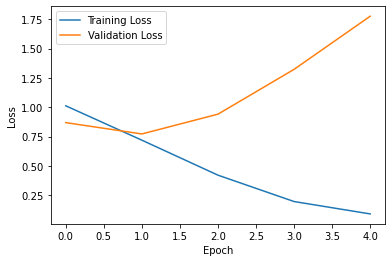

In [16]:
# plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
# save the trained model
model.save('../models/transformer_classification_model.h5')

In [49]:
model = load_model('../models/transformer_classification_model.h5')

In [50]:
# Evaluate the model on validation data
loss, accuracy = model.evaluate(x_val, y_val)
print('Validation loss:', loss)
print('Validation accuracy:', accuracy)

63/63 [==============================] - 1s 16ms/step - loss: 0.8872 - accuracy: 0.6424
Validation loss: 0.8872432708740234
Validation accuracy: 0.6424272656440735
